[Run the code](https://colab.research.google.com/drive/1KiHjrTVGYOIk_twVgjTexveWrwlvGvO6?usp=sharing)

# Importing Dependencies

**Trax** framework is much more concise than TensorFlow and PyTorch. It runs on a TensorFlow backend but allows US to train models with one line commands. Trax also runs end to end, allowing you to get data, model and train all with a single terse statements. Trax is good for implementing new state of the art algorithms like Transformers, Reformers, BERT because it is actively maintained by Google Brain Team for advanced deep learning tasks. It runs smoothly on CPUs,GPUs and TPUs as well with comparatively lesser modifications in code. 

In [1]:
# Trax version 1.3.9 or better 
!pip install -q trax

     |████████████████████████████████| 637 kB 10.3 MB/s 
     |████████████████████████████████| 4.6 MB 47.3 MB/s 
     |████████████████████████████████| 511.7 MB 5.7 kB/s 
     |████████████████████████████████| 1.6 MB 42.8 MB/s 
     |████████████████████████████████| 5.8 MB 30.6 MB/s 
     |████████████████████████████████| 438 kB 51.1 MB/s 


In [2]:
# import relevant libraries
import string
import re
import os
import nltk
import os 
import shutil
import random as rnd
import trax
import trax.fastmath.numpy as np
from trax import layers as tl
from trax import fastmath

nltk.download('stopwords')
from nltk.corpus import stopwords # Stop words are messy and not that compelling; 
stopwords_english = stopwords.words('english') # "very" and "not" are considered stop words, but they are obviously expressing sentiment

nltk.download('twitter_samples')
from nltk.corpus import twitter_samples 

from nltk.stem import PorterStemmer # The porter stemmer lemmatizes "was" to "wa".  Seriously???
stemmer = PorterStemmer() # Making an object

from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


# PRE-PROCESSING

## Loading Data

In [3]:
def load_tweets():
    all_positive_tweets = twitter_samples.strings('positive_tweets.json')
    all_negative_tweets = twitter_samples.strings('negative_tweets.json')  
    return all_positive_tweets, all_negative_tweets

In [4]:
def train_val_split():
    # Load positive and negative tweets
    all_positive_tweets, all_negative_tweets = load_tweets()

    # View the total number of positive and negative tweets.
    print(f"The number of positive tweets: {len(all_positive_tweets)}")
    print(f"The number of negative tweets: {len(all_negative_tweets)}")

    # Split positive set into validation and training
    val_pos   = all_positive_tweets[4000:] # generating validation set for positive tweets
    train_pos  = all_positive_tweets[:4000]# generating training set for positive tweets

    # Split negative set into validation and training
    val_neg   = all_negative_tweets[4000:] # generating validation set for negative tweets
    train_neg  = all_negative_tweets[:4000] # generating training set for nagative tweets
    
    # Combine training data into one set
    train_x = train_pos + train_neg 

    # Combine validation data into one set
    val_x  = val_pos + val_neg

    # Set the labels for the training set (1 for positive, 0 for negative)
    train_y = np.append(np.ones(len(train_pos)), np.zeros(len(train_neg)))

    # Set the labels for the validation set (1 for positive, 0 for negative)
    val_y  = np.append(np.ones(len(val_pos)), np.zeros(len(val_neg)))


    return train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y

In [5]:
train_pos, train_neg, train_x, train_y, val_pos, val_neg, val_x, val_y = train_val_split()
print(f"length of train_x:- {len(train_x)}")
print(f"length of val_x:-  {len(val_x)}")

The number of positive tweets: 5000
The number of negative tweets: 5000
length of train_x:- 8000
length of val_x:-  2000


## Pre Processing Tweets

In [6]:
def process_tweet(tweet):
    '''
    Input: 
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet
    
    '''
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet) # ['hi', 'i', 'am', 'vaasu']

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and # remove stopwords
            word not in string.punctuation): # remove punctuation
            #tweets_clean.append(word)
            stem_word = stemmer.stem(word) # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean

## Building the vocabulary

In [7]:
def get_vocab(train_x):

    # Include special tokens 
    # started with pad, end of line and unk tokens
    Vocab = {'__PAD__': 0, '__</e>__': 1, '__UNK__': 2} 

    # Note that we build vocab using training data
    for tweet in train_x: 
        processed_tweet = process_tweet(tweet)
        for word in processed_tweet:
            if word not in Vocab: 
                Vocab[word] = len(Vocab)
    
    return Vocab

Vocab = get_vocab(train_x)

print("Total words in vocab are",len(Vocab))
#display(Vocab)

Total words in vocab are 9089


- Each unique word has a unique integer associated with it.
- The total number of words in Vocab: 9088

## Converting a tweet to a tensor

This function will convert each tweet to a tensor (a list of unique integer IDs representing the processed tweet).
- Note, the returned data type will be a **regular Python `list()`**
    - You won't use TensorFlow in this function
    - You also won't use a numpy array
    - You also won't use trax.fastmath.numpy array
- For words in the tweet that are not in the vocabulary, set them to the unique ID for the token `__UNK__`.

##### Example
Input a tweet:
```CPP
'@happypuppy, is Maria happy?'
```

The tweet_to_tensor will first conver the tweet into a list of tokens (including only relevant words)
```CPP
['maria', 'happi']
```

Then it will convert each word into its unique integer

```CPP
[2, 56]
```
- Notice that the word "maria" is not in the vocabulary, so it is assigned the unique integer associated with the `__UNK__` token, because it is considered "unknown."

In [8]:
def tweet_to_tensor(tweet, vocab_dict, unk_token='__UNK__', verbose=False):
    '''
    Input: 
        tweet - A string containing a tweet
        vocab_dict - The words dictionary
        unk_token - The special string for unknown tokens
        verbose - Print info durign runtime
    Output:
        tensor_l - A python list with
        
    '''  
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    # Process the tweet into a list of words
    # where only important words are kept (stop words removed)
    word_l = process_tweet(tweet)
    
    if verbose:
        print("List of words from the processed tweet:")
        print(word_l)
        
    # Initialize the list that will contain the unique integer IDs of each word
    tensor_l = []
    
    # Get the unique integer ID of the __UNK__ token
    unk_ID = vocab_dict.get(unk_token)
    
    if verbose:
        print(f"The unique integer ID for the unk_token is {unk_ID}")
        
    # for each word in the list:
    for word in word_l:
        
        # Get the unique integer ID.
        # If the word doesn't exist in the vocab dictionary,
        # use the unique ID for __UNK__ instead.
        word_ID = vocab_dict.get(word if word in vocab_dict else unk_token)
    ### END CODE HERE ###
        
        # Append the unique integer ID to the tensor list.
        tensor_l.append(word_ID) 
    
    return tensor_l

In [9]:
print("Actual tweet is\n", val_pos[0])
print("\nTensor of tweet:\n", tweet_to_tensor(val_pos[0], vocab_dict=Vocab))

Actual tweet is
 Bro:U wan cut hair anot,ur hair long Liao bo
Me:since ord liao,take it easy lor treat as save $ leave it longer :)
Bro:LOL Sibei xialan

Tensor of tweet:
 [1064, 136, 478, 2351, 744, 8149, 1122, 744, 53, 2, 2671, 790, 2, 2, 348, 600, 2, 3488, 1016, 596, 4558, 9, 1064, 157, 2, 2]


## Creating a batch generator

Most of the time in Natural Language Processing, and AI in general we use batches when training our data sets. 
- If instead of training with batches of examples, we were to train a model with one example at a time, it would take a very long time to train the model. 
- we will now build a data generator that takes in the positive/negative tweets and returns a batch of training examples. It returns the model inputs, the targets (positive or negative labels) and the weight for each target (ex: this allows us to can treat some examples as more important to get right than others, but commonly this will all be 1.0). 

Once we create the generator, we could include it in a for loop
```CPP
for batch_inputs, batch_targets, batch_example_weights in data_generator:
    ...
```

We can also get a single batch like this:

```CPP
batch_inputs, batch_targets, batch_example_weights = next(data_generator)
```
The generator returns the next batch each time it's called. 
- This generator returns the data in a format (tensors) that we could directly use in our model.
- It returns a triplet: the inputs, targets, and loss weights:
    - Inputs is a tensor that contains the batch of tweets we put into the model.
    - Targets is the corresponding batch of labels that we train to generate.
    - Loss weights here are just 1s with same shape as targets. Next week, we will use it to mask input padding.

In [10]:
def data_generator(data_pos, data_neg, batch_size, loop, vocab_dict, shuffle=False):
    '''
    Input: 
        data_pos - Set of posstive examples
        data_neg - Set of negative examples
        batch_size - number of samples per batch. Must be even
        loop - True or False
        vocab_dict - The words dictionary
        shuffle - Shuffle the data order
    Yield:
        inputs - Subset of positive and negative examples
        targets - The corresponding labels for the subset
        example_weights - An array specifying the importance of each example
        
    '''     
    # make sure the batch size is an even number
    # to allow an equal number of positive and negative samples
    assert batch_size % 2 == 0
    
    # Number of positive examples in each batch is half of the batch size
    # same with number of negative examples in each batch
    n_to_take = batch_size // 2
    
    # Use pos_index to walk through the data_pos array
    # same with neg_index and data_neg
    pos_index = 0
    neg_index = 0
    
    len_data_pos = len(data_pos)
    len_data_neg = len(data_neg)
    
    # Get and array with the data indexes
    pos_index_lines = list(range(len_data_pos))
    neg_index_lines = list(range(len_data_neg))
    
    # shuffle lines if shuffle is set to True
    if shuffle:
        rnd.shuffle(pos_index_lines)
        rnd.shuffle(neg_index_lines)
        
    stop = False
    
    # Loop indefinitely
    while not stop:  
        
        # create a batch with positive and negative examples
        batch = []
        
        # First part: Pack n_to_take positive examples
        
        # Start from pos_index and increment i up to n_to_take
        for i in range(n_to_take):
                    
            # If the positive index goes past the positive dataset lenght,
            if pos_index >= len_data_pos: 
                
                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True;
                    break;
                
                # If user wants to keep re-using the data, reset the index
                pos_index = 0
                
                if shuffle:
                    # Shuffle the index of the positive sample
                    rnd.shuffle(pos_index_lines)
                    
            # get the tweet as pos_index
            tweet = data_pos[pos_index_lines[pos_index]]
            
            # convert the tweet into tensors of integers representing the processed words
            tensor = tweet_to_tensor(tweet, vocab_dict)
            
            # append the tensor to the batch list
            batch.append(tensor)
            
            # Increment pos_index by one
            pos_index = pos_index + 1


        # Second part: Pack n_to_take negative examples
    
        # Using the same batch list, start from neg_index and increment i up to n_to_take
        for i in range(n_to_take):
            
            # If the negative index goes past the negative dataset length,
            if neg_index >= len_data_neg:
                
                # If loop is set to False, break once we reach the end of the dataset
                if not loop:
                    stop = True;
                    break;
                    
                # If user wants to keep re-using the data, reset the index
                neg_index = 0
                
                if shuffle:
                    # Shuffle the index of the negative sample
                    rnd.shuffle(neg_index_lines)
            # get the tweet as neg_index
            tweet = data_neg[neg_index_lines[neg_index]]
            
            # convert the tweet into tensors of integers representing the processed words
            tensor = tweet_to_tensor(tweet,vocab_dict)
            
            # append the tensor to the batch list
            batch.append(tensor)
            
            # Increment neg_index by one
            neg_index = neg_index + 1

        if stop:
            break;

        # Update the start index for positive data 
        # so that it's n_to_take positions after the current pos_index
        pos_index += n_to_take
        
        # Update the start index for negative data 
        # so that it's n_to_take positions after the current neg_index
        neg_index += n_to_take
        
        # Get the max tweet length (the length of the longest tweet) 
        # (you will pad all shorter tweets to have this length)
        max_len = max([len(t) for t in batch]) 
        
        
        # Initialize the input_l, which will 
        # store the padded versions of the tensors
        tensor_pad_l = []
        # Pad shorter tweets with zeros
        for tensor in batch:

            # Get the number of positions to pad for this tensor so that it will be max_len long
            n_pad = max_len - len(tensor)
            
            # Generate a list of zeros, with length n_pad
            pad_l = [0 for _ in range(n_pad)]
            
            # concatenate the tensor and the list of padded zeros
            tensor_pad = tensor + pad_l
            
            # append the padded tensor to the list of padded tensors
            tensor_pad_l.append(tensor_pad)

        # convert the list of padded tensors to a numpy array
        # and store this as the model inputs
        inputs = np.asarray(tensor_pad_l)
  
        # Generate the list of targets for the positive examples (a list of ones)
        # The length is the number of positive examples in the batch
        target_pos = [1 for _ in range(n_to_take)]
        
        # Generate the list of targets for the negative examples (a list of zeros)
        # The length is the number of negative examples in the batch
        target_neg = [0 for _ in range(n_to_take)]
        
        # Concatenate the positve and negative targets
        target_l = target_pos + target_neg
        
        # Convert the target list into a numpy array
        targets = np.asarray(target_l)

        # Example weights: Treat all examples equally importantly.It should return an np.array. Hint: Use np.ones_like()
        example_weights = np.ones_like(targets)
        

        # note we use yield and not return
        yield inputs, targets, example_weights

In [11]:
# Set the random number generator for the shuffle procedure
rnd.seed(30) 

# Create the training data generator

def train_generator(batch_size, train_pos
                    , train_neg, vocab_dict, loop=True
                    , shuffle = False):
    return data_generator(train_pos, train_neg, batch_size, loop, vocab_dict, shuffle)

# Create the validation data generator
def val_generator(batch_size, val_pos
                    , val_neg, vocab_dict, loop=True
                    , shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, loop, vocab_dict, shuffle)

# Create the validation data generator
def test_generator(batch_size, val_pos
                    , val_neg, vocab_dict, loop=False
                    , shuffle = False):
    return data_generator(val_pos, val_neg, batch_size, loop, vocab_dict, shuffle)

# Get a batch from the train_generator and inspect.
inputs, targets, example_weights = next(train_generator(4, train_pos, train_neg, Vocab, shuffle=True))

# this will print a list of 4 tensors padded with zeros
print(f'Inputs: {inputs}')
print(f'Targets: {targets}')
print(f'Example Weights: {example_weights}')

Inputs: [[2005 4450 3200    9    0    0    0    0    0    0    0]
 [4953  566 2000 1453 5173 3498  141 3498  130  458    9]
 [3760  109  136  582 2929 3968    0    0    0    0    0]
 [ 249 3760    0    0    0    0    0    0    0    0    0]]
Targets: [1 1 0 0]
Example Weights: [1 1 1 1]


In [12]:
# Test the train_generator

# Create a data generator for training data,
# which produces batches of size 4 (for tensors and their respective targets)
tmp_data_gen = train_generator(batch_size = 4, train_pos=train_pos, train_neg=train_neg, vocab_dict=Vocab)

# Call the data generator to get one batch and its targets
tmp_inputs, tmp_targets, tmp_example_weights = next(tmp_data_gen)

print(f"The inputs shape is {tmp_inputs.shape}")
for i,t in enumerate(tmp_inputs):
    print(f"input tensor: {t}; target {tmp_targets[i]}; example weights {tmp_example_weights[i]}")

The inputs shape is (4, 14)
input tensor: [3 4 5 6 7 8 9 0 0 0 0 0 0 0]; target 1; example weights 1
input tensor: [10 11 12 13 14 15 16 17 18 19 20  9 21 22]; target 1; example weights 1
input tensor: [5737 2900 3760    0    0    0    0    0    0    0    0    0    0    0]; target 0; example weights 1
input tensor: [ 857  255 3651 5738  306 4457  566 1229 2766  327 1201 3760    0    0]; target 0; example weights 1


# Modelling

In [13]:
# Layers have weights and a foward function.
# They create weights when layer.initialize is called and use them.
# remove this or make it optional 

class Layer(object):
    """Base class for layers."""
    def __init__(self):
        self.weights = None

    def forward(self, x):
        raise NotImplementedError
  
    def init_weights_and_state(self, input_signature, random_key):
        pass

    def init(self, input_signature, random_key):
        self.init_weights_and_state(input_signature, random_key)
        return self.weights
    
    def __call__(self, x):
        return self.forward(x)

In [14]:
class Relu(Layer):
    """Relu activation function implementation"""
    def forward(self, x):
        '''
        Input: 
            - x (a numpy array): the input
        Output:
            - activation (numpy array): all positive or 0 version of x
        '''
        activation = np.maximum(x,0)
        return activation

In [15]:
# Test your relu function
x = np.array([[-2.0, -1.0, 0.0], [0.0, 1.0, 2.0]], dtype=float)
relu_layer = Relu()
print("Test data is:")
print(x)
print("Output of Relu is:")
print(relu_layer(x))

Test data is:
[[-2. -1.  0.]
 [ 0.  1.  2.]]
Output of Relu is:
[[0. 0. 0.]
 [0. 1. 2.]]


In [16]:
# See how the trax.fastmath.random.normal function works
tmp_key = trax.fastmath.random.get_prng(seed=1)
print("The random seed generated by random.get_prng")
display(tmp_key)

print("choose a matrix with 2 rows and 3 columns")
tmp_shape=(2,3)
display(tmp_shape)

# Generate a weight matrix
# Note that you'll get an error if you try to set dtype to tf.float32, where tf is tensorflow
# Just avoid setting the dtype and allow it to use the default data type
tmp_weight = trax.fastmath.random.normal(key=tmp_key, shape=tmp_shape)

print("Weight matrix generated with a normal distribution with mean 0 and stdev of 1")
display(tmp_weight)

The random seed generated by random.get_prng


DeviceArray([0, 1], dtype=uint32)

choose a matrix with 2 rows and 3 columns


(2, 3)

Weight matrix generated with a normal distribution with mean 0 and stdev of 1


DeviceArray([[ 0.95730704, -0.9699289 ,  1.0070665 ],
             [ 0.3661903 ,  0.1729483 ,  0.29092234]], dtype=float32)

In [17]:
class Dense(Layer):
    """
    A dense (fully-connected) layer.
    """

    # __init__ is implemented for you
    def __init__(self, n_units, init_stdev=0.1):
        
        # Set the number of units in this layer
        self._n_units = n_units
        self._init_stdev = init_stdev

    # Please implement 'forward()'
    def forward(self, x):

### START CODE HERE (Replace instances of 'None' with your code) ###

        # Matrix multiply x and the weight matrix
        dense = np.dot(x,self.weights)
        
### END CODE HERE ###
        return dense

    # init_weights
    def init_weights_and_state(self, input_signature, random_key):
        
### START CODE HERE (Replace instances of 'None' with your code) ###
        # The input_signature has a .shape attribute that gives the shape as a tuple
        input_shape = input_signature.shape

        # Generate the weight matrix from a normal distribution, 
        # and standard deviation of 'stdev'        
        w = self._init_stdev*trax.fastmath.random.normal(key=random_key, shape=(input_shape[-1],self._n_units))
        
### END CODE HERE ###     
        self.weights = w
        return self.weights


For the model implementation, we will use the Trax `layers` module, imported as `tl`.

Note that the second character of `tl` is the lowercase of letter `L`, not the number 1. Trax layers are very similar to the ones we implemented above,
but in addition to trainable weights also have a non-trainable state.
State is used in layers like batch normalization and for inference, we will learn more about it in course 4.

First, look at the code of the Trax Dense layer and compare to our implementation above.
- [tl.Dense](https://github.com/google/trax/blob/master/trax/layers/core.py#L29): Trax Dense layer implementation

One other important layer that we will use a lot is one that allows to execute one layer after another in sequence.
- [tl.Serial](https://github.com/google/trax/blob/master/trax/layers/combinators.py#L26): Combinator that applies layers serially.  
    - we can pass in the layers as arguments to `Serial`, separated by commas. 
    - For example: `tl.Serial(tl.Embeddings(...), tl.Mean(...), tl.Dense(...), tl.LogSoftmax(...))`

Use the `help` function to view documentation for each layer.

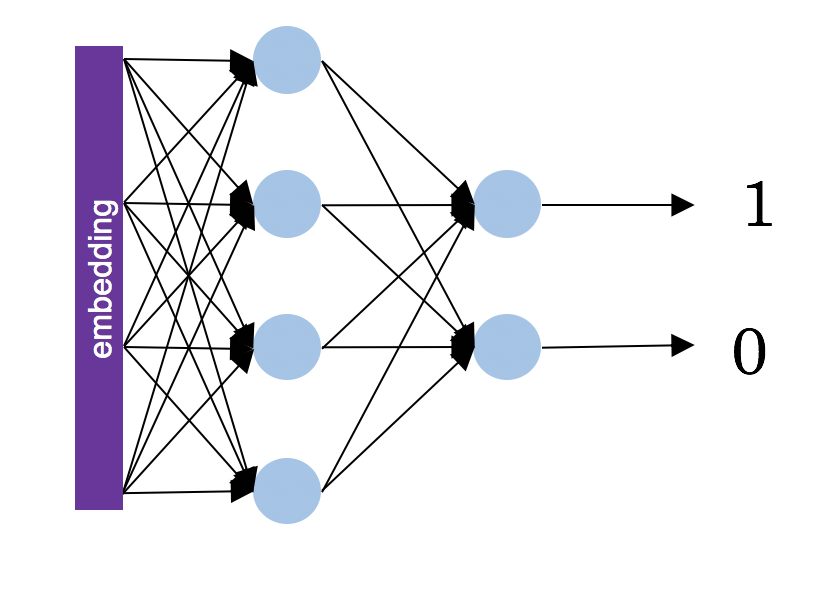

In [18]:
def classifier(vocab_size=len(Vocab), embedding_dim=256, output_dim=2, mode='train'):
        
    # create embedding layer
    embed_layer = tl.Embedding(
        vocab_size=vocab_size, # Size of the vocabulary
        d_feature=embedding_dim)  # Embedding dimension
    
    # Create a mean layer, to create an "average" word embedding
    mean_layer = tl.Mean(axis=1)
    
    # Create a dense layer, one unit for each output
    dense_output_layer = tl.Dense(n_units = output_dim)

    
    # Create the log softmax layer (no parameters needed)
    log_softmax_layer = tl.LogSoftmax()
    
    # Use tl.Serial to combine all layers
    # and create the classifier
    # of type trax.layers.combinators.Serial
    model = tl.Serial(
      embed_layer, # embedding layer
      mean_layer, # mean layer
      dense_output_layer, # dense output layer 
      log_softmax_layer # log softmax layer
    )
    
    # return the model of type
    return model

# Training

In [19]:
from trax.supervised import training

def get_train_eval_tasks(train_pos, train_neg, val_pos, val_neg, vocab_dict, loop, batch_size = 16):
    
    rnd.seed(271)

    train_task = training.TrainTask(
        labeled_data=train_generator(batch_size, train_pos
                    , train_neg, vocab_dict, loop
                    , shuffle = True),
        loss_layer=tl.WeightedCategoryCrossEntropy(),
        optimizer=trax.optimizers.Adam(0.01),
        n_steps_per_checkpoint=10,
    )

    eval_task = training.EvalTask(
        labeled_data=val_generator(batch_size, val_pos
                    , val_neg, vocab_dict, loop
                    , shuffle = True),        
        metrics=[tl.WeightedCategoryCrossEntropy(), tl.WeightedCategoryAccuracy()],#[tl.CrossEntropyLoss(), tl.Accuracy()],
    )
    
    return train_task, eval_task
    

train_task, eval_task = get_train_eval_tasks(train_pos, train_neg, val_pos, val_neg, Vocab, True, batch_size = 16)
model = classifier()

In [20]:
model

Serial[
  Embedding_9089_256
  Mean
  Dense_2
  LogSoftmax
]

In [21]:
dir_path = '/content/model/'

try:
    shutil.rmtree(dir_path)
except OSError as e:
    pass


output_dir = '/content/model'
output_dir_expand = os.path.expanduser(output_dir)
print(output_dir_expand)

/content/model


Implementing `train_model` to train the model (`classifier` that we wrote earlier) for the given number of training steps (`n_steps`) using `TrainTask`, `EvalTask` and `Loop`. For the `EvalTask`, take a look to the cell next to the function definition: the `eval_task` is passed as a list explicitly, so take that into account in the implementation of out  `train_model` function.

In [22]:
def train_model(classifier, train_task, eval_task, n_steps, output_dir):
    '''
    Input: 
        classifier - the model you are building
        train_task - Training task
        eval_task - Evaluation task. Received as a list.
        n_steps - the evaluation steps
        output_dir - folder to save your files
    Output:
        trainer -  trax trainer
    '''
    rnd.seed(31) # Do NOT modify this random seed. This makes the notebook easier to replicate
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###          
    training_loop = training.Loop( 
                                classifier, # The learning model
                                train_task, # The training task
                                eval_tasks=eval_task, # The evaluation task
                                output_dir=output_dir, # The output directory
                                random_seed=31 # Do not modify this random seed in order to ensure reproducibility and for grading purposes.
    ) 

    training_loop.run(n_steps = n_steps)
    ### END CODE HERE ###
    
    # Return the training_loop, since it has the model.
    return training_loop

In [23]:
training_loop = train_model(model, train_task, [eval_task], 100, output_dir_expand)

/usr/local/lib/python3.7/dist-packages/jax/_src/lib/xla_bridge.py:446: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "



Step      1: Total number of trainable weights: 2327298
Step      1: Ran 1 train steps in 1.60 secs
Step      1: train WeightedCategoryCrossEntropy |  0.69015592
Step      1: eval  WeightedCategoryCrossEntropy |  0.68020153
Step      1: eval      WeightedCategoryAccuracy |  0.62500000

Step     10: Ran 9 train steps in 3.72 secs
Step     10: train WeightedCategoryCrossEntropy |  0.64311719
Step     10: eval  WeightedCategoryCrossEntropy |  0.58531135
Step     10: eval      WeightedCategoryAccuracy |  0.68750000

Step     20: Ran 10 train steps in 5.32 secs
Step     20: train WeightedCategoryCrossEntropy |  0.48278910
Step     20: eval  WeightedCategoryCrossEntropy |  0.34539065
Step     20: eval      WeightedCategoryAccuracy |  1.00000000

Step     30: Ran 10 train steps in 1.59 secs
Step     30: train WeightedCategoryCrossEntropy |  0.24702363
Step     30: eval  WeightedCategoryCrossEntropy |  0.07668982
Step     30: eval      WeightedCategoryAccuracy |  1.00000000

Step     40: Ran 

# Evaluation

## Computing the accuracy on a batch

Writing a function that evaluates the model on the validation set and returns the accuracy. 
- `preds` contains the predictions.
    - Its dimensions are `(batch_size, output_dim)`.  `output_dim` is two in this case.  Column 0 contains the probability that the tweet belongs to class 0 (negative sentiment). Column 1 contains probability that it belongs to class 1 (positive sentiment).
    - If the probability in column 1 is greater than the probability in column 0, then interpret this as the model's prediction that the example has label 1 (positive sentiment).  
    - Otherwise, if the probabilities are equal or the probability in column 0 is higher, the model's prediction is 0 (negative sentiment).
- `y` contains the actual labels.
- `y_weights` contains the weights to give to predictions

In [24]:
def compute_accuracy(preds, y, y_weights):
    """
    Input: 
        preds: a tensor of shape (dim_batch, output_dim) 
        y: a tensor of shape (dim_batch,) with the true labels
        y_weights: a n.ndarray with the a weight for each example
    Output: 
        accuracy: a float between 0-1 
        weighted_num_correct (np.float32): Sum of the weighted correct predictions
        sum_weights (np.float32): Sum of the weights
    """
    # Create an array of booleans, 
    # True if the probability of positive sentiment is greater than
    # the probability of negative sentiment
    # else False
    is_pos = preds[:,1] > preds[:,0]

    # convert the array of booleans into an array of np.int32
    is_pos_int = is_pos.astype(np.int32)
    
    # compare the array of predictions (as int32) with the target (labels) of type int32
    correct = is_pos_int == y

    # Count the sum of the weights.
    sum_weights = sum(y_weights)
    
    # convert the array of correct predictions (boolean) into an arrayof np.float32
    correct_float = correct.astype(np.float32)
    
    # Multiply each prediction with its corresponding weight.
    weighted_correct_float = correct_float*y_weights

    # Sum up the weighted correct predictions (of type np.float32), to go in the
    # denominator.
    weighted_num_correct = sum(weighted_correct_float)

    # Divide the number of weighted correct predictions by the sum of the
    # weights.
    accuracy = weighted_num_correct/sum_weights
    
    return accuracy, weighted_num_correct, sum_weights

In [25]:
tmp_val_generator = val_generator(64, val_pos
                    , val_neg, Vocab, loop=True
                    , shuffle = False)

# get one batch
tmp_batch = next(tmp_val_generator)

# Position 0 has the model inputs (tweets as tensors)
# position 1 has the targets (the actual labels)
tmp_inputs, tmp_targets, tmp_example_weights = tmp_batch

# feed the tweet tensors into the model to get a prediction
tmp_pred = training_loop.eval_model(tmp_inputs)
tmp_acc, tmp_num_correct, tmp_num_predictions = compute_accuracy(preds=tmp_pred, y=tmp_targets, y_weights=tmp_example_weights)

print(f"Model's prediction accuracy on a single training batch is: {100 * tmp_acc}%")
print(f"Weighted number of correct predictions {tmp_num_correct}; weighted number of total observations predicted {tmp_num_predictions}")

Model's prediction accuracy on a single training batch is: 100.0%
Weighted number of correct predictions 64.0; weighted number of total observations predicted 64


In [26]:
def test_model(generator, model):
    '''
    Input: 
        generator: an iterator instance that provides batches of inputs and targets
        model: a model instance 
    Output: 
        accuracy: float corresponding to the accuracy
    '''
    accuracy = 0.
    total_num_correct = 0
    total_num_pred = 0
    
    for batch in generator: 
        
        # Retrieve the inputs from the batch
        inputs = batch[0]
        
        # Retrieve the targets (actual labels) from the batch
        targets = batch[1]
        
        # Retrieve the example weight.
        example_weight = batch[-1]

        # Make predictions using the inputs
        pred = model(inputs)
        
        # Calculate accuracy for the batch by comparing its predictions and targets
        batch_accuracy, batch_num_correct, batch_num_pred = compute_accuracy(pred, targets, example_weight)
        
        # Update the total number of correct predictions
        # by adding the number of correct predictions from this batch
        total_num_correct += batch_num_correct
        
        # Update the total number of predictions 
        # by adding the number of predictions made for the batch
        total_num_pred += batch_num_pred

    # Calculate accuracy over all examples
    accuracy = total_num_correct/total_num_pred
    
    return accuracy

In [27]:
model = training_loop.eval_model
accuracy = test_model(test_generator(16, val_pos
                    , val_neg, Vocab, loop=False
                    , shuffle = False), model)

print(f'The accuracy of your model on the validation set is {accuracy:.4f}', )

The accuracy of your model on the validation set is 0.9891


# Predicting

In [28]:
def predict(sentence):
    inputs = np.array(tweet_to_tensor(sentence, vocab_dict=Vocab))
    
    # Batch size 1, add dimension for batch, to work with the model
    inputs = inputs[None, :]  
    
    # predict with the model
    preds_probs = model(inputs)
    
    # Turn probabilities into categories
    preds = int(preds_probs[0, 1] > preds_probs[0, 0])
    
    sentiment = "negative"
    if preds == 1:
        sentiment = 'positive'

    return preds, sentiment

In [29]:
# try a positive sentence
sentence = "It's such a nice day, think i'll be taking Sid to Ramsgate fish and chips for lunch at Peter's fish factory and then the beach maybe"
tmp_pred, tmp_sentiment = predict(sentence)
print(f"The sentiment of the sentence \n***\n\"{sentence}\"\n***\nis {tmp_sentiment}.")

print()
# try a negative sentence
sentence = "I hated my day, it was the worst, I'm so sad."
tmp_pred, tmp_sentiment = predict(sentence)
print(f"The sentiment of the sentence \n***\n\"{sentence}\"\n***\nis {tmp_sentiment}.")

The sentiment of the sentence 
***
"It's such a nice day, think i'll be taking Sid to Ramsgate fish and chips for lunch at Peter's fish factory and then the beach maybe"
***
is positive.

The sentiment of the sentence 
***
"I hated my day, it was the worst, I'm so sad."
***
is negative.


# Word Embeddings

In [30]:
embeddings = model.weights[0]

In [31]:
# Look at the size of the embeddings.
embeddings.shape

(9089, 256)

To visualize the word embeddings, it is necessary to choose 2 directions to use as axes for the plot. Here I used random directions or the first two eigenvectors from PCA. Here I used scikit-learn to perform dimensionality reduction of the word embeddings using PCA.

In [32]:
from sklearn.decomposition import PCA #Import PCA from scikit-learn
pca = PCA(n_components=2) #PCA with two dimensions

emb_2dim = pca.fit_transform(embeddings) #Dimensionality reduction of the word embeddings

Ploting a selection of words in 2d.

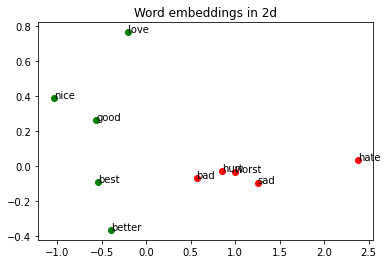

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt

#Selection of negative and positive words
neg_words = ['worst', 'bad', 'hurt', 'sad', 'hate']
pos_words = ['best', 'good', 'nice', 'better', 'love']

#Index of each selected word
neg_n = [Vocab[w] for w in neg_words]
pos_n = [Vocab[w] for w in pos_words]

plt.figure()

#Scatter plot for negative words
plt.scatter(emb_2dim[neg_n][:,0],emb_2dim[neg_n][:,1], color = 'r')
for i, txt in enumerate(neg_words): 
    plt.annotate(txt, (emb_2dim[neg_n][i,0],emb_2dim[neg_n][i,1]))

#Scatter plot for positive words
plt.scatter(emb_2dim[pos_n][:,0],emb_2dim[pos_n][:,1], color = 'g')
for i, txt in enumerate(pos_words): 
    plt.annotate(txt,(emb_2dim[pos_n][i,0],emb_2dim[pos_n][i,1]))

plt.title('Word embeddings in 2d')

plt.show()

The word embeddings for this task seem to distinguish negative and positive meanings very well. However, clusters don't necessarily have similar words since you only trained the model to analyze overall sentiment. 

### On Deep Nets

Deep nets allow us to understand and capture dependencies that we would have not been able to capture with a simple linear regression, or logistic regression. 
- It also allows us to better use pre-trained embeddings for classification and tends to generalize better.